In [52]:
import requests
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as mplt
import plotly.express as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_digits
from sklearn import metrics

In [2]:
def connect_drill(query, caching=True, chunk_size: int = 0):
    #username = os.getenv("DRILLUSERNAME")
    host = 'https://proxima.bigdata.fh-aachen.de:8047'
    username = 'al7739s'
    password = 'tWtx4UYhTdUbPHumX3VixMhdi'
    headers = {'Content-Type': 'application/json',
               'Authorization': '%s:%s' % (username, password)}
    #headers = {'Authorization': username + ':' + password}
    if caching:
        headers["Cache-Control"] = "max-age=" + "1440"
    else:
        headers["Cache-Control"] = "max-age=" + "0"
    #if chunk_size > 0:
        #headers["format"] = "chunks:" + str(chunk_size)
    data = {'query': "{q}".format(q=query)}

    try:
        result = requests.post(host + '/query', json=data, headers=headers)
    except Exception as e:
        print("The drill-proxy is not reachable. Please check if you are in the FH-Aachen network.")
        raise (e)

    data = None
    try:
        data = pd.read_json(result.text)
        if data.empty:
            print('Result of query is empty!')
            print('Query was: ' + query)
    except ValueError:
        print("Something went wrong when converting the json string from the datasource to a pandas DataFrame.")
        print(result.text)
    return data

In [3]:
def get_PIR_presences(room: str = "H217"):
    dict_rooms = {'H217': 'Elsen', 'H216': 'Galla', 'H215': 'Remmy'}
    room = dict_rooms[room]
    
    query = """SELECT `timestamp`,`room`, `presence`, `co2_ppm`, `temperature_celsius`, `relative_humidity_percent` 
    FROM ipenv.data.`sensor_data` 
    WHERE `room` LIKE '{room}' 
    AND `timestamp` > 1627776000 
    ORDER BY `timestamp` ASC
    LIMIT 1000000""".format(room=room)
    
    pir_data = connect_drill(query, caching=True)
    
    pir_data["timestamp"].dt.tz_localize('Europe/Berlin')
    pir_data["timestamp"] = pir_data["timestamp"] + pd.Timedelta(hours=2)

    pir_data["presence"] = pir_data["presence"].astype(int)
    pir_data.head()
    
    pir_data = pir_data.groupby(pd.Grouper(key="timestamp", freq="5min")).mean()\
        .round(0).reset_index(drop=False)
    
    return pir_data

In [4]:
def encode_cyclical(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [5]:
df = get_PIR_presences()

In [6]:
df.dtypes

timestamp                    datetime64[ns]
presence                            float64
co2_ppm                             float64
temperature_celsius                 float64
relative_humidity_percent           float64
dtype: object

In [14]:
df_test = df
df_test = df_test.assign(hoursMinutesSeconds=lambda d: (d['timestamp'].dt.hour.astype('int') * 10000 + 
                                                        d['timestamp'].dt.minute.astype('int') * 100 + 
                                                       d['timestamp'].dt.second.astype('int')))

df_test['hour_sin'] = np.sin(2 * np.pi * df_test['hoursMinutesSeconds']/235959.0)
df_test['hour_cos'] = np.cos(2 * np.pi * df_test['hoursMinutesSeconds']/235959.0)

In [30]:
df_test

,timestamp,presence,co2_ppm,temperature_celsius,relative_humidity_percent,hoursMinutesSeconds,hour_sin,hour_cos
0,2021-08-01 02:00:00,0.0,378.0,25.0,44.0,20000,0.507746,0.861507
1,2021-08-01 02:05:00,0.0,377.0,25.0,44.0,20500,0.519170,0.854671
2,2021-08-01 02:10:00,0.0,377.0,25.0,44.0,21000,0.530503,0.847683
3,2021-08-01 02:15:00,0.0,380.0,25.0,44.0,21500,0.541742,0.840545
4,2021-08-01 02:20:00,0.0,381.0,25.0,44.0,22000,0.552885,0.833258
...,...,...,...,...,...,...,...,...
19434,2021-10-07 13:30:00,1.0,1005.0,22.0,55.0,133000,-0.389391,-0.921073
19435,2021-10-07 13:35:00,1.0,1018.0,22.0,55.0,133500,-0.401619,-0.915807
19436,2021-10-07 13:40:00,1.0,1021.0,22.0,55.0,134000,-0.413777,-0.910378
19437,2021-10-07 13:45:00,1.0,1043.0,22.0,55.0,134500,-0.425860,-0.904789


In [42]:
df_test = df_test.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
df_timestamp = df_test['timestamp']
y_presence = df_test['presence']
X_presence = df_test.drop(['timestamp', 'presence'], axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X_presence, y_presence, test_size=0.2, random_state=1, shuffle=False)

Xtrain

,co2_ppm,temperature_celsius,relative_humidity_percent,hoursMinutesSeconds,hour_sin,hour_cos
0,378.0,25.0,44.0,20000,0.507746,0.861507
1,377.0,25.0,44.0,20500,0.519170,0.854671
2,377.0,25.0,44.0,21000,0.530503,0.847683
3,380.0,25.0,44.0,21500,0.541742,0.840545
4,381.0,25.0,44.0,22000,0.552885,0.833258
...,...,...,...,...,...,...
15546,489.0,19.0,55.0,13000,0.339295,0.940680
15547,488.0,19.0,55.0,13500,0.351789,0.936079
15548,490.0,19.0,56.0,14000,0.364221,0.931313
15549,487.0,19.0,56.0,14500,0.376588,0.926381


In [53]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

print(metrics.classification_report(ypred, ytest))
#y_pred = model.predict(Xtest)
#accuracy_score(ytest, y_pred)

              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91      2925
         1.0       0.78      0.63      0.70       963

    accuracy                           0.87      3888
   macro avg       0.84      0.79      0.81      3888
weighted avg       0.86      0.87      0.86      3888



Text(91.68, 0.5, 'predicted label')

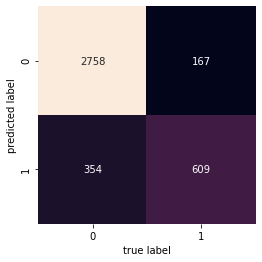

In [54]:
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
mplt.xlabel('true label')
mplt.ylabel('predicted label')

In [55]:
df_valid = Xtest.copy()
df_valid['timestamp'] = df_timestamp
df_valid['prediction'] = y_pred
df_valid['presence'] = ytest

plt.scatter(df_valid, x='timestamp', y='prediction', color='presence')